In [1]:
from collections import deque
import tqdm
import bench_utils
from shapely.geometry import shape
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
import random
import numpy as np
from shapely.geometry import shape
from intersection.plotting import xs, ys
import shapely 

fpd = FpdExtended()

#df, _ = bench_utils.read_dataset("data/world_7_dec.json")
df, _ = bench_utils.read_dataset()

MEMORY_SLOTS = 4
USE_FLAT_LIST = True
NORMALIZE_PLACEMENT = True

# Export delta properties
x, y = [], []
bins = []
normalization_offset = []
for idx in tqdm.tqdm(range(len(df)), disable=True): # List of single idxs
    geom = shape(df.iloc[idx])
    bounds = shapely.bounds(geom)
    normalization_offset.append([bounds[0], bounds[1]])
    _, bin = fpd.compress(geom)
    type = 0 if shapely.get_type_id(geom) == 1 else 0

    chunks, _ = fpd.get_chunks(bin, include_ring_start=False)
    bins.append(bin)
    X_shape = []
    y_shape = []
    for c in chunks:
        if NORMALIZE_PLACEMENT:
            c = [[p[0] - bounds[0], p[1] - bounds[1]] for p in c]
        prevs = [(c[0])]
        for coord in c[1:]:
            if len(prevs) > MEMORY_SLOTS:
                prevs.pop()

            X_small = [prevs[i] if len(prevs) > i else [np.NaN, np.NaN] for i in range(MEMORY_SLOTS)]
            extra_features = [type, shapely.get_num_coordinates(geom)]
            y_small = coord
            prevs.insert(0, coord)

            if len(prevs) < MEMORY_SLOTS:
                continue

            if USE_FLAT_LIST:
                X_shape.append([*xs(X_small), *ys(X_small)] + extra_features)
            else:
                X_shape.append(X_small)
            y_shape.append(y_small)

    if len(X_shape) > 0:
        x.append((idx, X_shape))
        y.append(y_shape)

In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn.neural_network import MLPRegressor
x = np.array(x, dtype=object)
y = np.array(y, dtype=object)

2023-04-21 20:34:34.202508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 20:34:34.238700: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-21 20:34:34.239655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 20:34:34.851199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(x.shape)
#X = X.reshape((-1, X.shape[1] * X.shape[2]))
#print(X.shape)
print(y.shape)

(13012, 2)
(13012,)


In [4]:
print(x)
print(y)

[[1
  list([[3.460000000110597e-05, 3.120000000045309e-05, 0.0, nan, 0.00015590000000287318, 0.00014770000000652317, 0.0, nan, 0, 13], [3.91000000004027e-05, 3.460000000110597e-05, 3.120000000045309e-05, 0.0, 0.0001639000000039914, 0.00015590000000287318, 0.00014770000000652317, 0.0, 0, 13], [4.4700000000119644e-05, 3.91000000004027e-05, 3.460000000110597e-05, 3.120000000045309e-05, 0.00017180000000394102, 0.0001639000000039914, 0.00015590000000287318, 0.00014770000000652317, 0, 13], [5.180000000137852e-05, 4.4700000000119644e-05, 3.91000000004027e-05, 3.460000000110597e-05, 0.00017850000000407817, 0.00017180000000394102, 0.0001639000000039914, 0.00015590000000287318, 0, 13], [6.150000000104683e-05, 5.180000000137852e-05, 4.4700000000119644e-05, 3.91000000004027e-05, 0.00018410000000557147, 0.00017850000000407817, 0.00017180000000394102, 0.0001639000000039914, 0, 13], [7.24000000005276e-05, 6.150000000104683e-05, 5.180000000137852e-05, 4.4700000000119644e-05, 0.0001886000000013155, 0.0

In [5]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(x, y, random_state=50,test_size=0.3)
X_validation, X_test, y_validation, y_test = model_selection.train_test_split(X_validation, y_validation, random_state=50,test_size=0.3)

def scramble_and_unpack(X, y):
    '''
    Returns the ID of the shape and scrambles the chunks within the data set.
    Note that the steps above are done in order to avoid overlap (using the same shape)
    between the different sets.
    '''
    X_shapes = [x[0] for x in X]
        
    X_stripped = [x[1] for x in X]
    X_stripped = [item for sublist in X_stripped for item in sublist]
    
    X_long_shapes = []
    for i in range(len(X_shapes)):
        X_long_shapes += [X_shapes[i] for _ in range(len(X[i][1]))]
    
    y_flat = [item for sublist in y for item in sublist]
    X_shapes, X_stripped, y_flat = shuffle(X_long_shapes, X_stripped, y_flat, random_state=0)

    X_stripped = np.array(X_stripped)
    y_flat = np.array(y_flat)

    return np.array(X_shapes), X_stripped, y_flat

train_geometries, X_train, y_train = scramble_and_unpack(X_train, y_train)
validation_geometries, X_validation, y_validation = scramble_and_unpack(X_validation, y_validation)
test_geometries, X_test, y_test = scramble_and_unpack(X_test, y_test)

print('train data shape:',np.shape(X_train))
print('validation data shape:',np.shape(X_validation))
print('train labels shape:',np.shape(y_train))
print('validation labels shape:',np.shape(y_validation))
print('test labels shape:',np.shape(X_test))
print('test labels shape:',np.shape(y_test))

train data shape: (56503, 10)
validation data shape: (15831, 10)
train labels shape: (56503, 2)
validation labels shape: (15831, 2)
test labels shape: (6606, 10)
test labels shape: (6606, 2)


In [6]:
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)

#train_data = (train_data-mean) / std
#validation_data = (validation_data-mean) / std

#print(train_data)
print(mean, std)

[8.95658231e-04 8.90127177e-04 8.77533750e-04            nan
 5.42170147e-04 5.46150624e-04 5.49237626e-04            nan
 0.00000000e+00 1.49702901e+02] [1.62612226e-03 1.61597746e-03 1.61533574e-03            nan
 9.89662676e-04 9.89523716e-04 9.93543391e-04            nan
 0.00000000e+00 5.07175910e+02]


In [7]:
X_train[0]

array([2.5400e-05, 0.0000e+00, 4.1000e-06,        nan, 2.7836e-03,
       3.0044e-03, 3.1277e-03,        nan, 0.0000e+00, 1.7000e+01])

In [8]:
y_train[0]

array([3.1300e-05, 2.6235e-03])

In [9]:
X_validation[0]

array([1.5655e-03, 1.7569e-03, 1.9432e-03, 2.1259e-03, 2.7590e-04,
       2.4940e-04, 2.2360e-04, 1.9830e-04, 0.0000e+00, 2.2000e+01])

In [10]:
import gc
gc.collect() # used to clear gpu memory 

0

In [11]:
if False: 
    neural_net = MLPRegressor(max_iter=2000).fit(X_train, y_train)
    ## Result
    y_hat = neural_net.predict(X_validation)

    PRINT_VALIDATION = False

    pred_better_cnt = 0
    for i in range(len(y_hat)):
        prev = X_validation[i][0:2]
        predicted_is_better =  np.linalg.norm(y[i] - y_hat[i]) < np.linalg.norm(y[i] - prev)
        pred_better_cnt = pred_better_cnt + 1 if predicted_is_better else pred_better_cnt
        if PRINT_VALIDATION:
            print(prev)
            print(f'{i + 1}: Diff: {y[i] - y_hat[i]}   predicted {y_hat[i]}     distance {np.linalg.norm(y[i] - y_hat[i])}')
            print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
            print('Better:', 'YES' if predicted_is_better else 'NO')

    print("Model was better in:", pred_better_cnt, '/', len(y_hat), '   (', f'{(pred_better_cnt/len(y_hat) * 100):f}%' , ')')

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, concatenate, Input, Dropout, BatchNormalization

input_shape=np.shape(X_train)[1:]

# Define the model architecture
# model = Sequential()
# model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True))
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dense(units=2, activation='linear'))
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# model = Sequential()
# model.add(LSTM(64, input_shape=input_shape))
# model.add(Dense(2))
# model.compile(loss="mean_squared_error", optimizer="adam")

# model = Sequential()
# model.add(LSTM(units=256, input_shape=input_shape, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(units=2, activation='linear'))
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# model = keras.models.Sequential([
#     keras.layers.Input(shape=input_shape),
#     keras.layers.Dense(75, activation="relu"),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(35, activation="relu"),
#     keras.layers.Dense(2, activation="linear")])
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

model = LinearRegression().fit(X_train, y_train)
#model = DecisionTreeRegressor().fit(X_train, y_train)
#model = KNeighborsRegressor().fit(X_train, y_train)
#model = Ridge().fit(X_train, y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
# history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

179.99815538434785


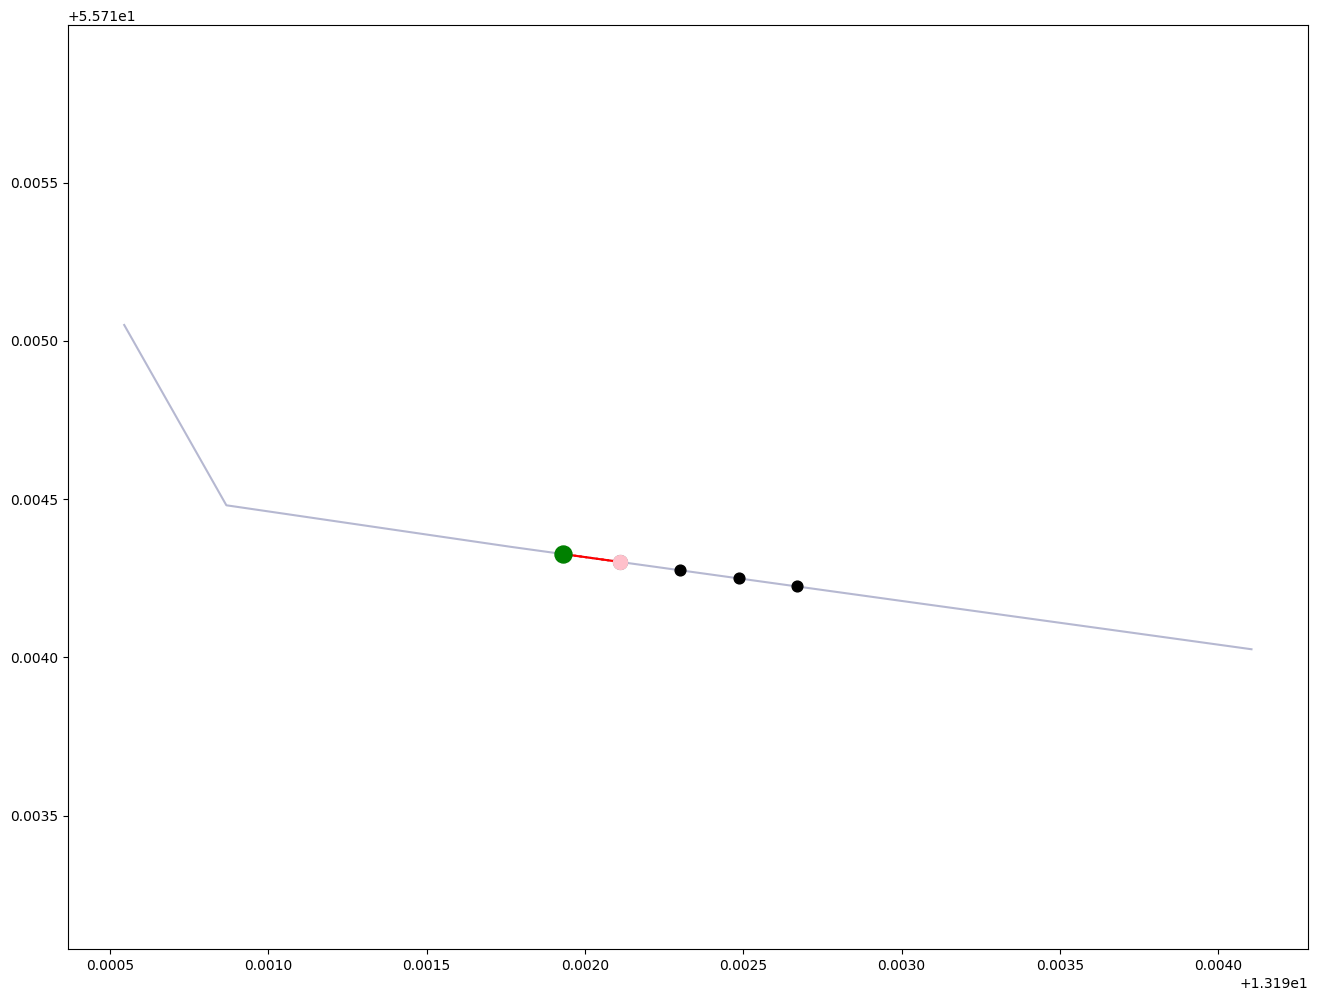

147.05871830300663


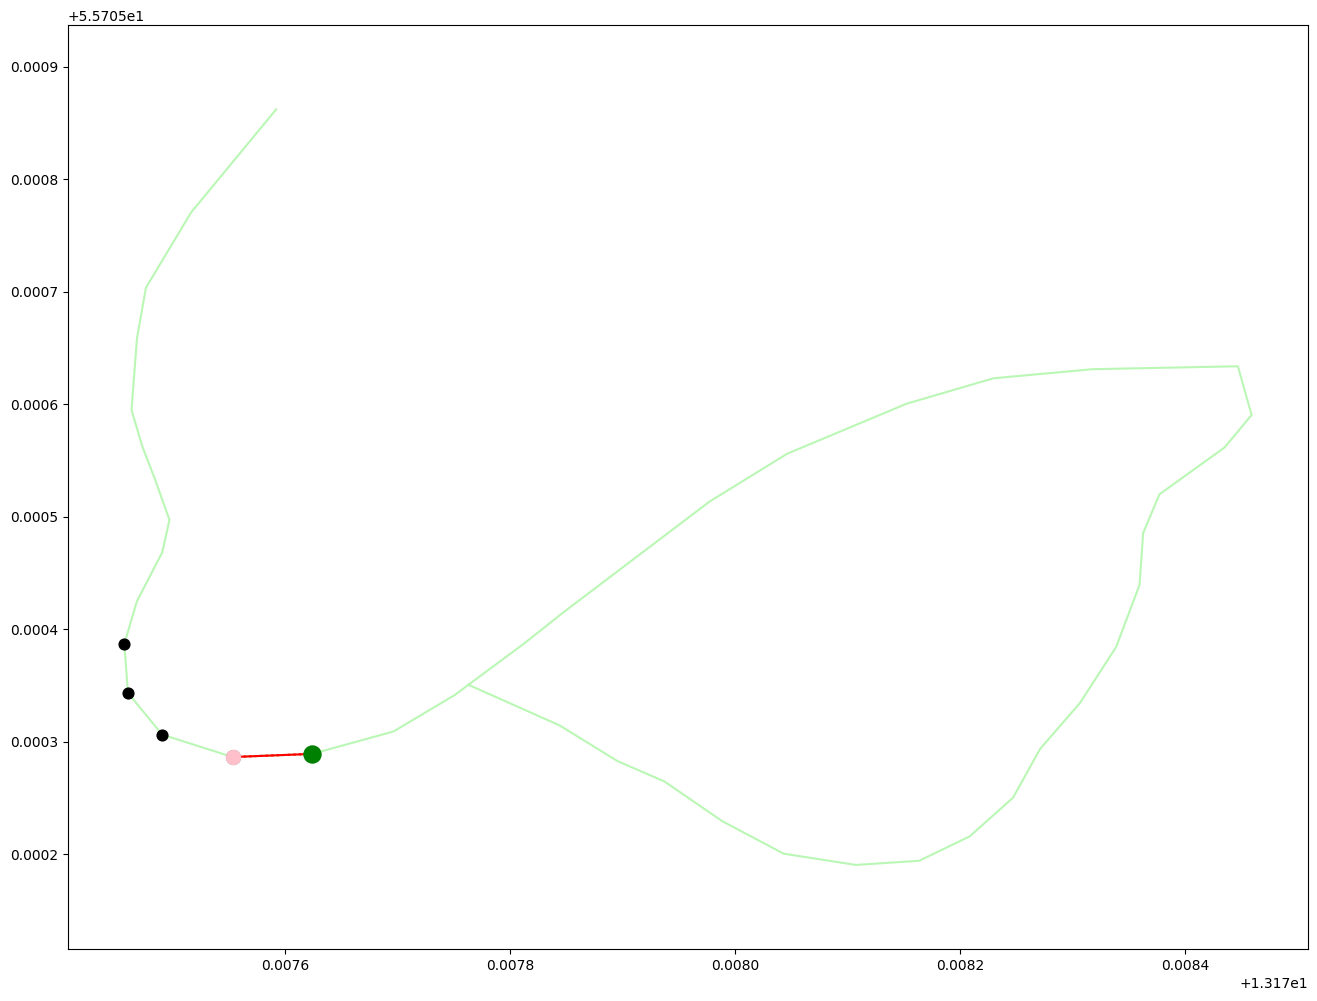

155.29268169867473


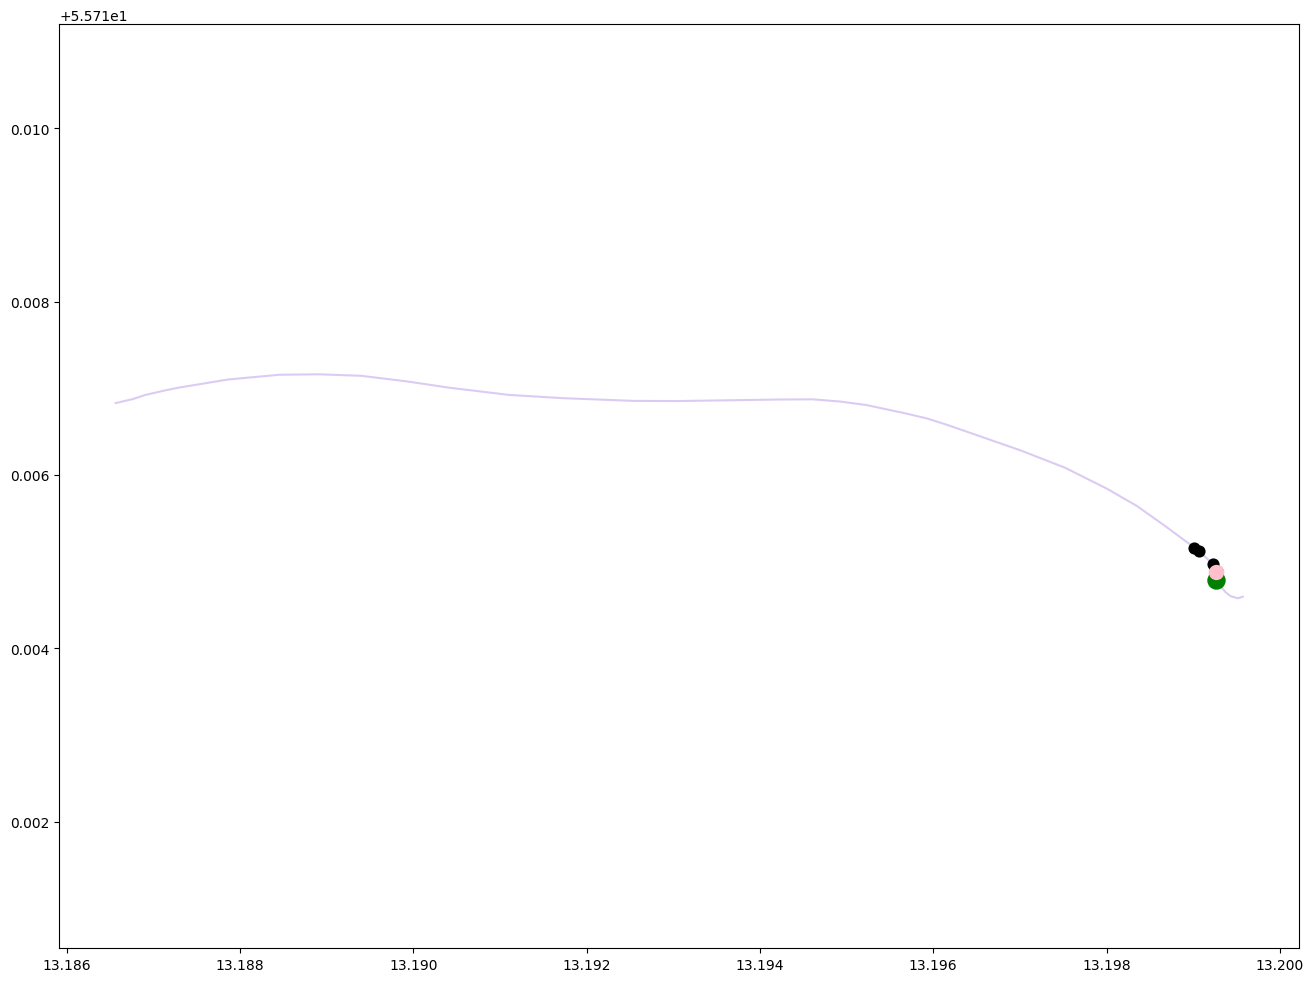

70.05629772885642


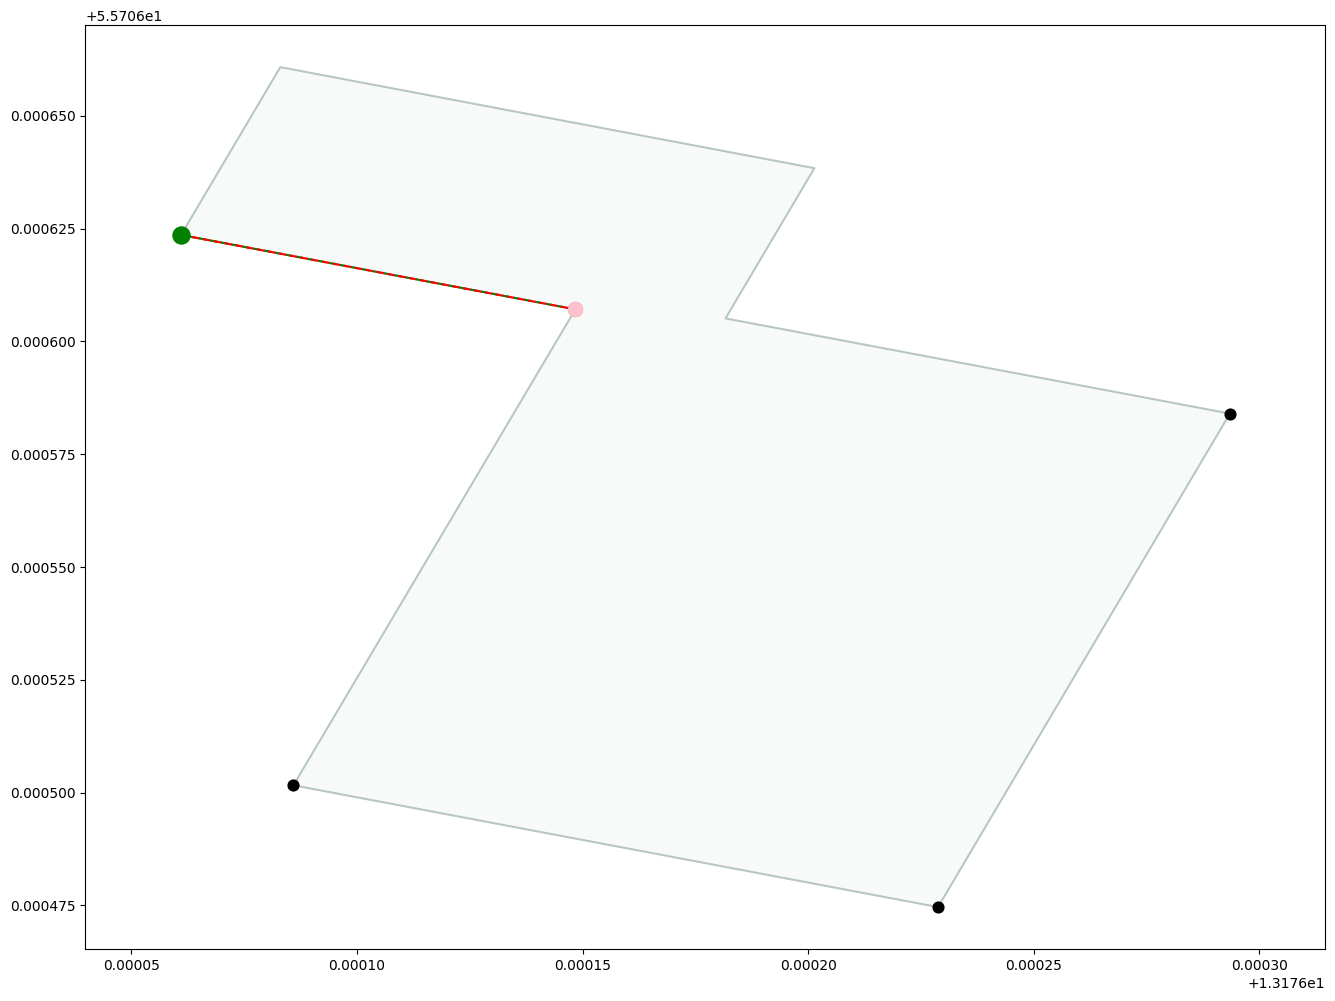

116.6443728521493


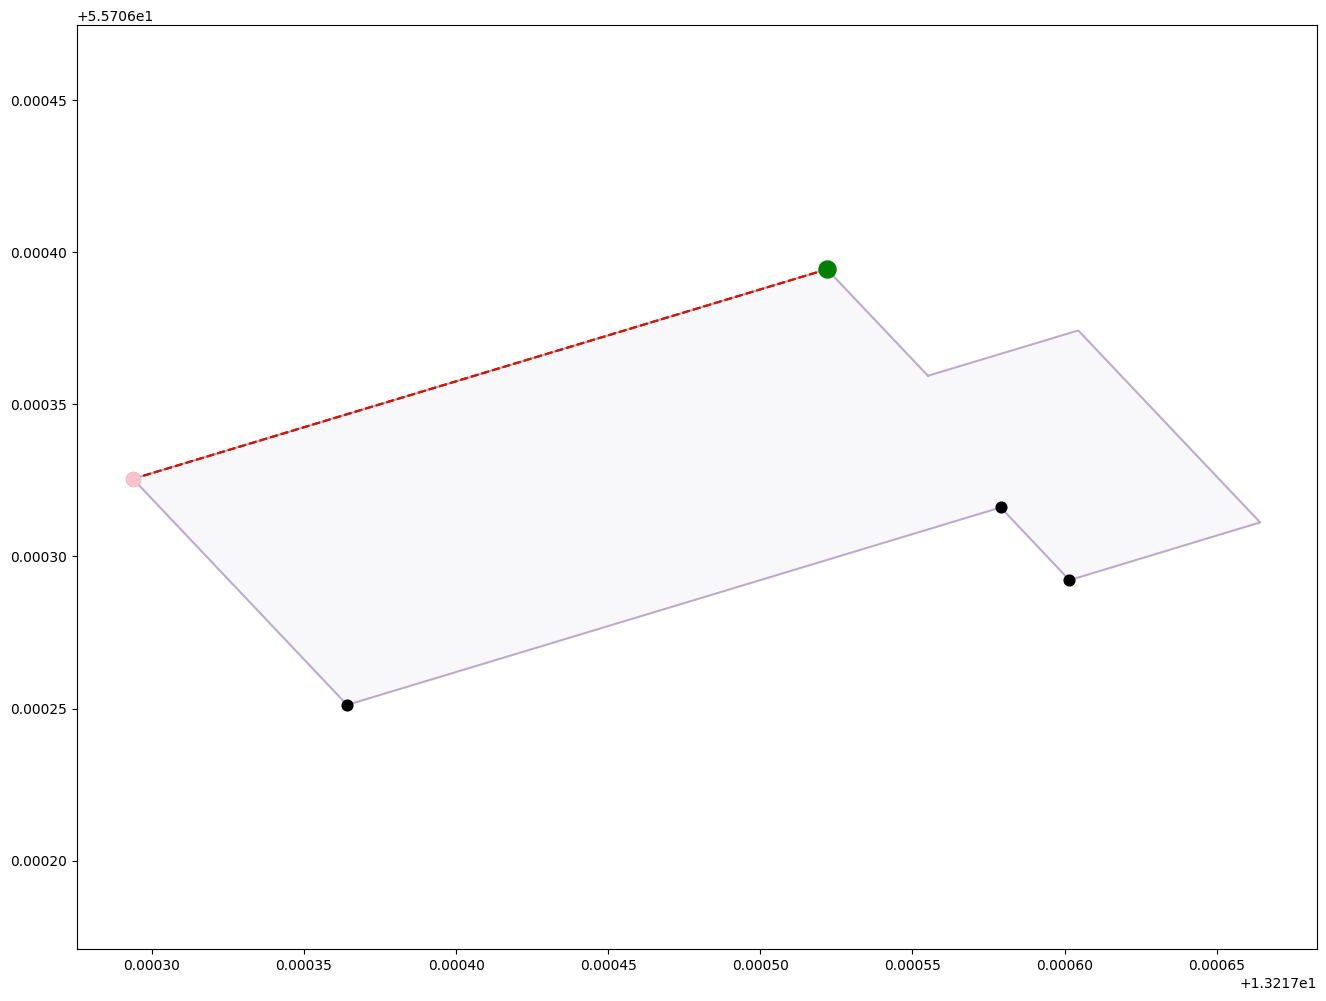

Linear was better than None in: 3 / 5    ( 60.000000% )
Total MSE Linear: 0.0005563526986840751
Total MSE None: 0.0006648278647262808
MSE Ratio (lower means Linear is better): 83.683721%

Angle was better than None in: 0 / 5    ( 0.000000% )
Total MSE Angle: 0.0006648278647262808
Total MSE None: 0.0006648278647262808
MSE Ratio (lower means Angle is better): 100.000000%



In [14]:
from intersection.plotting import plot_geometry, create_canvas, plot_raw_points, plot_raw_point, plot_line

PRINT_VALIDATION = False
DRAW_MODEL_PREDICT = True

def flat_to_coord(x, idx=None):
    sep = len(x) // 2
    if idx != None:
        return np.array([x[idx], x[sep + idx]]) if USE_FLAT_LIST else x[idx]
    else:
        return np.array([[x[idx], x[sep + idx]] for idx in range(sep)]) if USE_FLAT_LIST else x
    
def denormalize(content, offset):
    return np.array([[p[0] + offset[0], p[1] + offset[1]] for p in content]) if NORMALIZE_PLACEMENT else content

def linear_pred(x, x_normalized):
    if x[0][0] == np.NaN:
        return np.array([0, 0])
    elif x[1][0] == np.NaN:
        return x[0]
    else:
        return x[0] + (x[0] - x[1])
    
def angle_pred(x, x_normalized):
    if x[0][0] == np.NaN: # Zero coords
        return np.array([0, 0])
    elif x[1][0] == np.NaN: # One previous coord
        return x[0]
    elif x[2][0] == np.NaN: # Two previous coords
        return x[0] + (x[0] - x[1])
    else: # At least three points
        # a: x[2], b: x[1], c: x[0]
        x_1_x_2 = x[2] - x[1]
        x_1_x_0 = x[0] - x[1]

        cosine_angle = np.dot(x_1_x_2, x_1_x_0) / (np.linalg.norm(x_1_x_2) * np.linalg.norm(x_1_x_0))
        angle = np.arccos(cosine_angle)

        last_length = np.linalg.norm(x_1_x_0)
        print(np.degrees(angle))

        origin_vector = x_1_x_0 - x[1]
        x_rotated = (origin_vector[0] * np.cos(angle)) - (origin_vector[1] * np.sin(angle))
        y_rotated = (origin_vector[0] * np.sin(angle)) + (origin_vector[1] * np.cos(angle))
       
        return x[0] 
    


def eval_set(geoms, X, y):
#    y_hat_all = model.predict(X)

    predictors = []
    ## Model
    # predictor = {}
    # predictor['func'] = lambda x_small, i, x_small_normalized: denormalize([y_hat_all[i]], normalization_offset[geoms[i]])[0]
    # predictor['color'] = 'blue'
    # predictor['draw'] = True
    # predictor['name'] = "ML Model"
    # predictors.append(predictor)

    ## Linear
    predictor = {}
    predictor['func'] = lambda x_small, i, x_small_normalized: linear_pred(x_small, x_small_normalized)
    predictor['color'] = 'orange'
    predictor['draw'] = False
    predictor['name'] = "Linear"
    predictor['extra_plot'] = lambda prev, y_pred, y_true: plot_line(prev, y_pred, solid=False, color=predictor['color'], alpha=0.3)
    predictors.append(predictor)

    ## Angle
    predictor = {}
    predictor['func'] = lambda x_small, i, x_small_normalized: angle_pred(x_small, x_small_normalized)
    predictor['color'] = 'pink'
    predictor['draw'] = True
    predictor['name'] = "Angle"
    predictor['extra_plot'] = lambda prev, y_pred, y_true: plot_line(prev, y_pred, solid=False, color=predictor['color'], alpha=0.3)
    predictors.append(predictor)

    
    all_errors = [] # Store errors/distances for all queries
    # TODO: Use test set instead!
    for i in range(len(y)):
        x_small_normalized = flat_to_coord(X[i][:MEMORY_SLOTS*2])
        x_small = denormalize(x_small_normalized, normalization_offset[geoms[i]])
        y_true = denormalize([y[i]], normalization_offset[geoms[i]])[0]
        prev = x_small[0]
        
        distances = []
        distances.append(np.linalg.norm(y_true - prev)) # Default
        y_preds = []
    
        for pred_idx, pred in enumerate(predictors):
            y_preds.append(pred['func'](x_small, i, x_small_normalized))
            y_pred = y_preds[-1]
            distances.append(np.linalg.norm(y_true - y_pred))
            if PRINT_VALIDATION:
                print(prev)
                print(f'{i + 1}: Diff: {y_true - y_pred}   predicted {y_pred}     distance {distances[-1]}')
                print(f'{i + 1}: Default: {y_true - prev}       was       {y_true})        distance {distances[0]}')
                print('Better:', 'YES' if distances[-1] < distances[0] else 'NO')
                print()

        all_errors.append(distances)

        if i % 1 == 0: # Draw?
            win_idx = np.argmin(distances)
            col_head = 'grey'
            col_tail = 'black'
            col_error = 'red'
            col_correct = 'green'
            idx = geoms[i]
            create_canvas()
            
            # Draw shape + points used in model
            plot_geometry(shape(df.iloc[idx]), alpha=0.3)
            plot_raw_point(prev, color=col_head, size=100)
            plot_raw_point(y_true, color=col_correct, size=150)
            x_non_zero = list(filter(lambda x: not all(x == [np.NaN, np.NaN]), x_small[1:]))
            plot_raw_points(x_non_zero, color=col_tail, size=60)
            plot_line(prev, y_true, solid=False, color=col_correct if win_idx == 0 else col_error)

            for pred_idx, pred in enumerate(predictors):
                if pred['draw']:
                    y_pred = y_preds[pred_idx]
                    plot_raw_point(y_pred, color=pred['color'], size=100)
                    plot_line(y_true, y_pred, solid=False, color=col_correct if win_idx == pred_idx + 1 else col_error)
                    if win_idx == pred_idx + 1:
                        plt.title("Prediction Accuracy - " + pred['name'] + " wins!")
                    if "extra_plot" in pred:
                        pred['extra_plot'](prev, y_pred, y_true)
            plt.axis('equal')
            plt.show()

    none_tot_mse = sum(d[0] for d in all_errors)
    for pred_idx, pred in enumerate(predictors):
        pred_better_cnt = sum([1 if d[pred_idx + 1] < d[0] else 0 for d in all_errors])
        pred_tot_mse = sum(d[pred_idx + 1] for d in all_errors)
        name = pred['name']

        print(name, "was better than None in:", pred_better_cnt, '/', len(y), '   (', f'{(pred_better_cnt/len(y) * 100):f}%' , ')')
        print("Total MSE " + name + ":", pred_tot_mse)
        print("Total MSE None:", none_tot_mse)
        print("MSE Ratio (lower means " + name + " is better):", f'{(pred_tot_mse/none_tot_mse * 100):f}%')
        print()

samples = 5 #len(X_validation)
eval_set(validation_geometries, X_validation[:samples], y_validation[:samples])